<a href="https://colab.research.google.com/github/isj0/DeepLearning/blob/main/Test_Run_NSL_KDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import ibraries and load dataset

In [98]:
# Import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import time


In [73]:
# load the NSL-KDD dataset from HuggingFace

print("Loading the NSL-KDD dataset from HuggingFace")
ds = load_dataset("Mireu-Lab/NSL-KDD")

Loading the NSL-KDD dataset from HuggingFace


In [74]:
# Hugging Face datasets need to be converted to pandas DataFrame for easy handling

# convert train and test splits to dataFrames
train_df = pd.DataFrame(ds['train'])
test_df = pd.DataFrame(ds['test'])

### Explore dataset

In [75]:
# preview a few first rows of the data

print(train_df.head())

   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                    0.10                    0.05   


In [77]:
# display shape of datasets

print("Training dataset shape:", train_df.shape)
print("Testing dataset shape:", test_df.shape)

Training dataset shape: (151165, 42)
Testing dataset shape: (34394, 42)


In [78]:
# display the column names

print("Columns in the dataset:")
print(train_df.columns)


Columns in the dataset:
Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')


In [79]:
# Check data types of each column
print("Data types of each column:")
print(train_df.dtypes)

Data types of each column:
duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float6

In [80]:
# check target class distribution

print("Attack types in training dataset:")
print(train_df['class'].value_counts())

Attack types in training dataset:
class
normal     80792
anomaly    70373
Name: count, dtype: int64


### Data Cleaning

In [81]:
# check for duplicate rows in training and test datasets

print("Number of duplicate rows in training set:", train_df.duplicated().sum())
print("Number of duplicate rows in test set:", test_df.duplicated().sum())


Number of duplicate rows in training set: 25201
Number of duplicate rows in test set: 11853


In [82]:
# Remove duplicate rows

train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()

# check for duplicate rows after removal
print("Number of duplicate rows in training set:", train_df.duplicated().sum())
print("Number of duplicate rows in test set:", test_df.duplicated().sum())


Number of duplicate rows in training set: 0
Number of duplicate rows in test set: 0


In [84]:
# Check for any missing values

print("Missing values in training set:\n", train_df.isnull().sum())
print("Missing values in test set:\n", test_df.isnull().sum())


Missing values in training set:
 duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_r

In [85]:
# convert the target column to numeric: normal=0, anomaly=1

train_df['label'] = train_df['class'].apply(lambda x: 0 if x=='normal' else 1)
test_df['label'] = test_df['class'].apply(lambda x: 0 if x=='normal' else 1)

# Now drop original class column
train_df.drop('class', axis=1, inplace=True)
test_df.drop('class', axis=1, inplace=True)


### Data preprocessing

In [86]:
# peform One-hot encoding for categorical features

categorical_features = ['protocol_type', 'service', 'flag']

# convert categorical features to one-hot encoded columns
train_df_encoded = pd.get_dummies(train_df, columns=categorical_features)
test_df_encoded = pd.get_dummies(test_df, columns=categorical_features)


In [87]:
# align train and test after one-hot encoding

train_df_encoded, test_df_encoded = train_df_encoded.align(test_df_encoded, join='left', axis=1, fill_value=0)

# now confirm they have the same number of columns

print("Training features shape:", train_df_encoded.shape)
print("Testing features shape:", test_df_encoded.shape)


Training features shape: (125964, 123)
Testing features shape: (22541, 123)


In [88]:
# Scale numeric features

# identify numeric columns
numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()
# remove target column from features
numeric_cols.remove('label')

print("Numeric columns to scale:", numeric_cols)


Numeric columns to scale: ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


In [89]:
# Next we initialize the scaler
scaler = StandardScaler()

# fit the scaler on training data numeric columns and transform
train_df_encoded[numeric_cols] = scaler.fit_transform(train_df_encoded[numeric_cols])

# transform the test data using the same scaler
test_df_encoded[numeric_cols] = scaler.transform(test_df_encoded[numeric_cols])

# check a few rows to see scaled numeric features
print("Numeric features scaled. Sample data:")
print(train_df_encoded[numeric_cols].head())

Numeric features scaled. Sample data:
   duration  src_bytes  dst_bytes      land  wrong_fragment    urgent  \
0 -0.110253  -0.007679  -0.004919 -0.014089        -0.08949 -0.007736   
1 -0.110253  -0.007738  -0.004919 -0.014089        -0.08949 -0.007736   
2 -0.110253  -0.007763  -0.004919 -0.014089        -0.08949 -0.007736   
3 -0.110253  -0.007723  -0.002891 -0.014089        -0.08949 -0.007736   
4 -0.110253  -0.007729  -0.004814 -0.014089        -0.08949 -0.007736   

        hot  num_failed_logins  logged_in  num_compromised  ...  \
0 -0.095079          -0.027024  -0.809310        -0.011664  ...   
1 -0.095079          -0.027024  -0.809310        -0.011664  ...   
2 -0.095079          -0.027024  -0.809310        -0.011664  ...   
3 -0.095079          -0.027024   1.235621        -0.011664  ...   
4 -0.095079          -0.027024   1.235621        -0.011664  ...   

   dst_host_count  dst_host_srv_count  dst_host_same_srv_rate  \
0       -0.324219           -0.818965               -0.

In [90]:
# apply PCA to reduce dimensionality
# we will keep enough components to retain 95% of variance

# separate features and target
X_train = train_df_encoded.drop('label', axis=1)
y_train = train_df_encoded['label']

X_test = test_df_encoded.drop('label', axis=1)
y_test = test_df_encoded['label']

# Initialize PCA to retain 95% of variance
pca = PCA(n_components=0.95, random_state=42)

# fit PCA on training features and transform
X_train_pca = pca.fit_transform(X_train)

# transform test features using the same PCA
X_test_pca = pca.transform(X_test)

# check how many components PCA kept
print("Original number of features:", X_train.shape[1])
print("Reduced number of features after PCA:", X_train_pca.shape[1])


Original number of features: 122
Reduced number of features after PCA: 24


In [91]:
# function to compute, store and key evaluation metrics.

# dictionary to store results
model_results = {}

def evaluation_metrics(y_true, y_pred, model_name="Model"):

    # compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # print metrics
    print(f"\n{model_name} Performance:")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")

    # store metrics in the global dictionary
    model_results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    }

    # return metrics dictionary
    return model_results[model_name]





In [92]:
# function to plot a confusion matrix as a heatmap for our models

def plot_confusion_matrix(y_true, y_pred, model_name="Model"):

    # compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # plotting
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{model_name} Confusion Matrix")
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")
    plt.show()



Logistic Regression Performance:
Accuracy : 0.7552
Precision: 0.9230
Recall   : 0.6217
F1-score : 0.7430


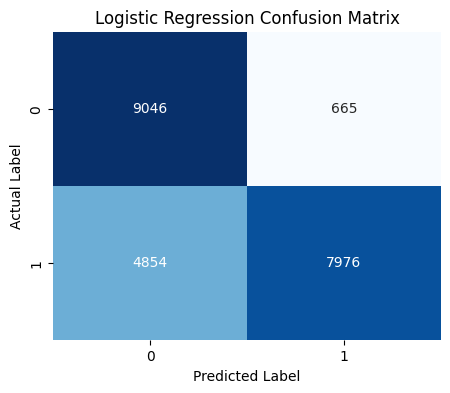

In [93]:
# Logistic Regression

# initialize the model
logreg = LogisticRegression(random_state=42, max_iter=1000)  # max_iter increased to ensure convergence

# fit the model on PCA-transformed training data
logreg.fit(X_train_pca, y_train)

# predict on test data
y_pred_logreg = logreg.predict(X_test_pca)

# evaluate metrics
evaluation_metrics(y_test, y_pred_logreg, model_name="Logistic Regression")

# plot confusion matrix
plot_confusion_matrix(y_test, y_pred_logreg, model_name="Logistic Regression")




Decision Tree Performance:
Accuracy : 0.7679
Precision: 0.9304
Recall   : 0.6401
F1-score : 0.7584


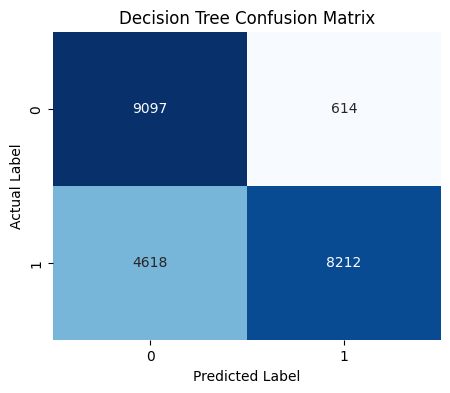

In [94]:
# Decision Tree

# initialize the Decision Tree
dt = DecisionTreeClassifier(random_state=42)

# fit the model on PCA-transformed training data
dt.fit(X_train_pca, y_train)

# Predict on test data
y_pred_dt = dt.predict(X_test_pca)

# evaluate metrics
evaluation_metrics(y_test, y_pred_dt, model_name="Decision Tree")

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_dt, model_name="Decision Tree")



Random Forest Performance:
Accuracy : 0.7321
Precision: 0.9290
Recall   : 0.5731
F1-score : 0.7089


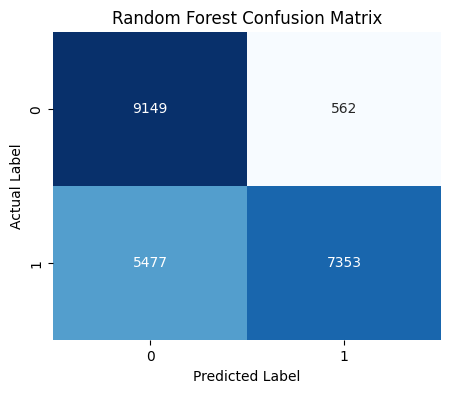

In [95]:
# Random Forest

# initialize the Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# fit the model on PCA-transformed training data
rf.fit(X_train_pca, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test_pca)

# evaluate metrics
evaluation_metrics(y_test, y_pred_rf, model_name="Random Forest")

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_rf, model_name="Random Forest")



SVM Performance:
Accuracy : 0.7660
Precision: 0.9232
Recall   : 0.6422
F1-score : 0.7575


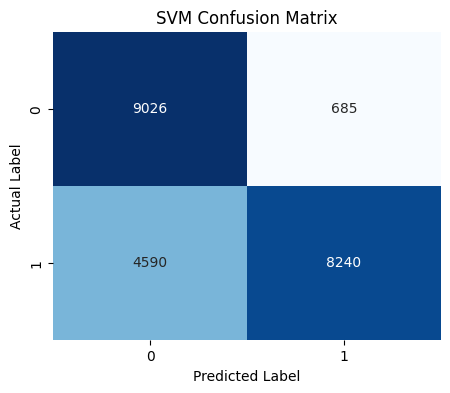

In [96]:
# Support Vector machine

# initialize the SVM with RBF kernel
svm_model = SVC(kernel='rbf', random_state=42)

# train the model on PCA-transformed training data
svm_model.fit(X_train_pca, y_train)

# predict on test data
y_pred_svm = svm_model.predict(X_test_pca)

# evaluate metrics
evaluation_metrics(y_test, y_pred_svm, model_name="SVM")

# plot confusion matrix
plot_confusion_matrix(y_test, y_pred_svm, model_name="SVM")



MLP Performance:
Accuracy : 0.7591
Precision: 0.9706
Recall   : 0.5948
F1-score : 0.7376


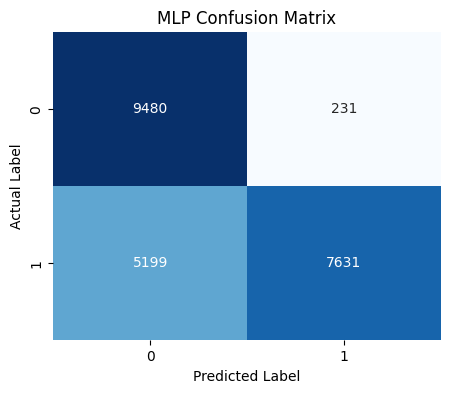

In [97]:
# Multilayer Perceptron

# initialize MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=200, random_state=42)

# train MLP
mlp_model.fit(X_train_pca, y_train)

# Predict on test data
y_pred_mlp = mlp_model.predict(X_test_pca)

# Evaluate metrics
evaluation_metrics(y_test, y_pred_mlp, model_name="MLP")

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_mlp, model_name="MLP")


1️⃣ PCA reduces dimensionality

You went from 122 features → 24 features.

PCA keeps ~95% of the variance, but some information is inevitably lost.

This can affect models like Random Forest, which can handle many features and might benefit from the full feature set.

2️⃣ Random Forest doesn’t require PCA

RF is tree-based, not linear, so it can naturally handle correlated or high-dimensional features.

PCA is more useful for linear models (like Logistic Regression, SVM with RBF) where too many correlated features can hurt performance or increase computation.

3️⃣ Compare results

Training RF on PCA features gave you one set of metrics.

Training RF on original features gives a baseline to see if PCA helped or hurt.

You might find that RF on original features has better recall or F1-score, especially for the minority class (anomalies).

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Random Forest tuning completed in 2995.79 seconds

Best Random Forest Hyperparameters:
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}

Random Forest (Tuned simple) Performance:
Accuracy : 0.7316
Precision: 0.9300
Recall   : 0.5714
F1-score : 0.7079


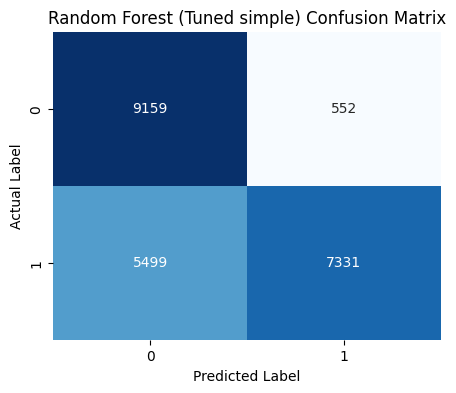

In [99]:
# Random Forest Hyperparameter Tuning using RandomizedSearchCV

# create a small set of parameters to test
rf_param_grid_fast = {
    "n_estimators": [50, 100, 200],       # num of trees
    "max_depth": [None, 10, 20],          # max depth of each tree
    "min_samples_split": [2, 5, 10],      # min samples to split a node
    "min_samples_leaf": [1, 2, 4],        # min samples at leaf
    "max_features": ["sqrt", 0.5],        # features considered per split
    "bootstrap": [True]                    # use bootstrap samples
}

# create a random forest model
rf = RandomForestClassifier(random_state=42)

# set up RandomizedSearchCV to find best parameters
rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid_fast,
    n_iter=10,          # try only 10 random combinations
    cv=3,               # 3-fold cross validation
    scoring='f1',       # focus on F1 due to class imbalance
    verbose=2,
    random_state=42,
    n_jobs=-1           # use all CPU cores
)

# Train the model and measure time
start_time = time.time()
rf_search.fit(X_train_pca, y_train)
end_time = time.time()

print(f"Random Forest tuning completed in {end_time - start_time:.2f} seconds")

# Show the best hyperparameters
print("\nBest Random Forest Hyperparameters:")
print(rf_search.best_params_)

# predict on test data
y_pred_rf_best = rf_search.best_estimator_.predict(X_test_pca)

# evaluation metrics and confusion matrix
evaluation_metrics(y_test, y_pred_rf_best, model_name="Random Forest (Tuned simple)")
plot_confusion_matrix(y_test, y_pred_rf_best, model_name="Random Forest (Tuned simple)")


Training Random Forest on original features

Random Forest (No PCA) Performance:
Accuracy : 0.7694
Precision: 0.9681
Recall   : 0.6150
F1-score : 0.7522


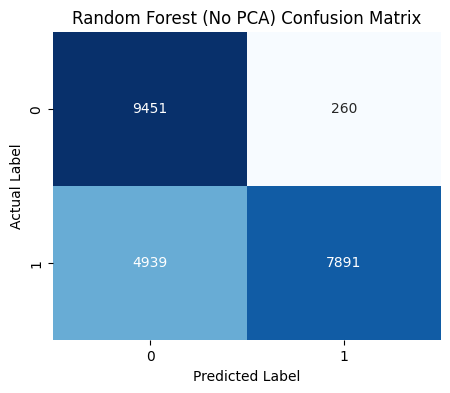

In [100]:
# Random Forest on all original features (No PCA)

print("Training Random Forest on original features")

rf_no_pca = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# train random forest on all features
rf_no_pca.fit(X_train, y_train)

# predictions
y_pred_rf_no_pca = rf_no_pca.predict(X_test)

# evaluation
evaluation_metrics(y_test, y_pred_rf_no_pca, model_name="Random Forest (No PCA)")
plot_confusion_matrix(y_test, y_pred_rf_no_pca, model_name="Random Forest (No PCA)")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
SVM tuning completed in 3099.69 seconds

Best SVM Hyperparameters found:
{'kernel': 'rbf', 'gamma': 0.1, 'C': 50}

SVM (Tuned) Performance:
Accuracy : 0.7626
Precision: 0.9690
Recall   : 0.6022
F1-score : 0.7428


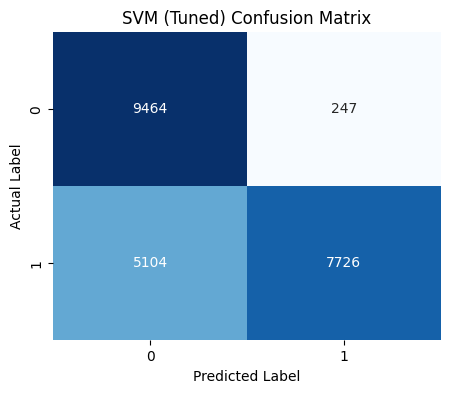

In [101]:
# SVM hyperparameter tuning setup using RandomizedSearchCV:
# We want to find the best SVM settings for our data

# choose some SVM options to try
svm_options = {
    'C': [0.1, 1, 10, 50],         # penalty
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf']              # RBF kernel
}

# create the svm model
svm_model = SVC(random_state=42)

# try different settings
# RandomizedSearchCV will try 10 combinations of the options with 3-fold CV

svm_search = RandomizedSearchCV(
    estimator=svm_model,
    param_distributions=svm_options,
    n_iter=10,        # try 10 random combinations
    cv=3,             # 3-fold cross-validation
    scoring='f1',       # focus on F1-score due to class imbalance
    verbose=2,
    random_state=42,
    n_jobs=-1         # use all CPU cores
)

# fit with PCA reduced training data
start_time = time.time()
svm_search.fit(X_train_pca, y_train)
end_time = time.time()

print(f"SVM tuning completed in {end_time - start_time:.2f} seconds")

# see which setting worked
best_svm = svm_search.best_estimator_
print("\nBest SVM Hyperparameters found:")
print(svm_search.best_params_)

# Test the best SVM on our test data
y_pred_svm = best_svm.predict(X_test_pca)

# evaluations
evaluation_metrics(y_test, y_pred_svm, model_name="SVM (Tuned)")
plot_confusion_matrix(y_test, y_pred_svm, model_name="SVM (Tuned)")


Gradient Boosting Performance:
Accuracy : 0.7675
Precision: 0.9273
Recall   : 0.6419
F1-score : 0.7587


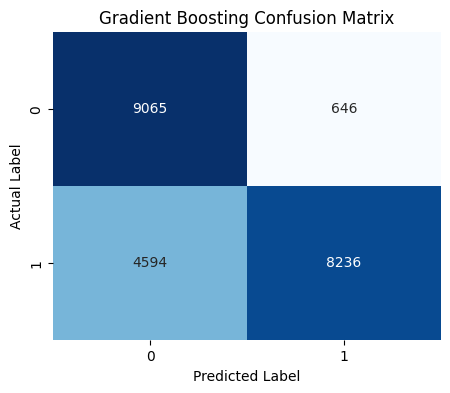

In [106]:
# Gradient Boosting Classifier

# create the model
gb = GradientBoostingClassifier(
    # number of trees
    n_estimators=150,
    # learning rate
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

# Train the model on PCA-reduced training data
gb.fit(X_train_pca, y_train)

# Predict on test data
y_pred_gb = gb.predict(X_test_pca)

# evaluation
evaluation_metrics(y_test, y_pred_gb, model_name="Gradient Boosting")
plot_confusion_matrix(y_test, y_pred_gb, model_name="Gradient Boosting")




Isolation Forest Performance:
Accuracy : 0.7954
Precision: 0.8068
Recall   : 0.8423
F1-score : 0.8242


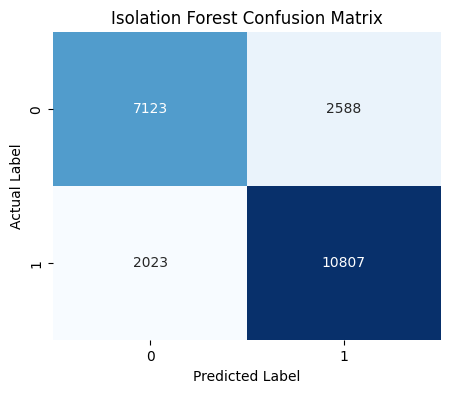

In [107]:
# Isolation Forest (Unsupervised model)

# create the model
iso = IsolationForest(
    # num of trees
    n_estimators=200,
    contamination=y_train.mean(),  # ratio of attacks in data
    max_samples='auto',         # samples each tree uses
    random_state=42,
    n_jobs=-1
)

# Train the model using features only -no labels
iso.fit(X_train)

# predict on test data (-1 = anomaly, 1 = normal)
y_pred_iso = iso.predict(X_test)

# Convert the output to 0 (normal) / 1 (attack)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)

# evaluate performace
evaluation_metrics(y_test, y_pred_iso, model_name="Isolation Forest")
plot_confusion_matrix(y_test, y_pred_iso, model_name="Isolation Forest")




Hybrid Ensemble Performance:
Accuracy : 0.8475
Precision: 0.8223
Recall   : 0.9339
F1-score : 0.8746


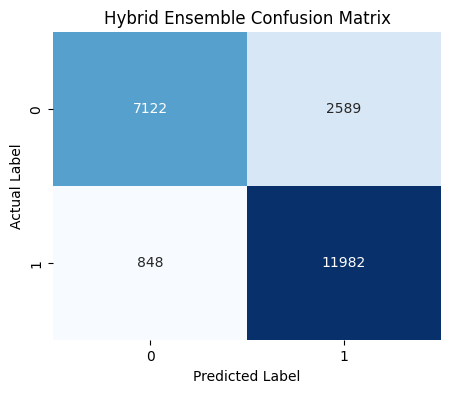

In [108]:
# Hybrid Ensemble: Gradient Boosting + Isolation Forest

# supervised model predictions - gradient boosting
gb_pred = y_pred_gb

# Unsupervised model predictions - Isolation Forest
iso_pred = y_pred_iso

# Ensemble prediction using OR rule
ensemble_pred = ((gb_pred == 1) | (iso_pred == 1)).astype(int)

# evaluate ensemble
evaluation_metrics(y_test, ensemble_pred, model_name="Hybrid Ensemble")
plot_confusion_matrix(y_test, ensemble_pred, model_name="Hybrid Ensemble")


In [110]:
# Summarize all model metrics in a table

# convert the model_results dictionary into a dataframe

results_df = pd.DataFrame(model_results).T

# sort the models by F1-score
results_df = results_df.sort_values(by="F1", ascending=False)

display(results_df.style.background_gradient(cmap="Blues").format("{:.4f}"))

,Accuracy,Precision,Recall,F1
Hybrid Ensemble,0.8475,0.8223,0.9339,0.8746
Isolation Forest,0.7954,0.8068,0.8423,0.8242
Gradient Boosting,0.7675,0.9273,0.6419,0.7587
Decision Tree,0.7679,0.9304,0.6401,0.7584
SVM,0.7660,0.9232,0.6422,0.7575
Random Forest (No PCA),0.7694,0.9681,0.6150,0.7522
Logistic Regression,0.7552,0.9230,0.6217,0.7430
SVM (Tuned),0.7626,0.9690,0.6022,0.7428
MLP,0.7591,0.9706,0.5948,0.7376
Random Forest,0.7321,0.9290,0.5731,0.7089


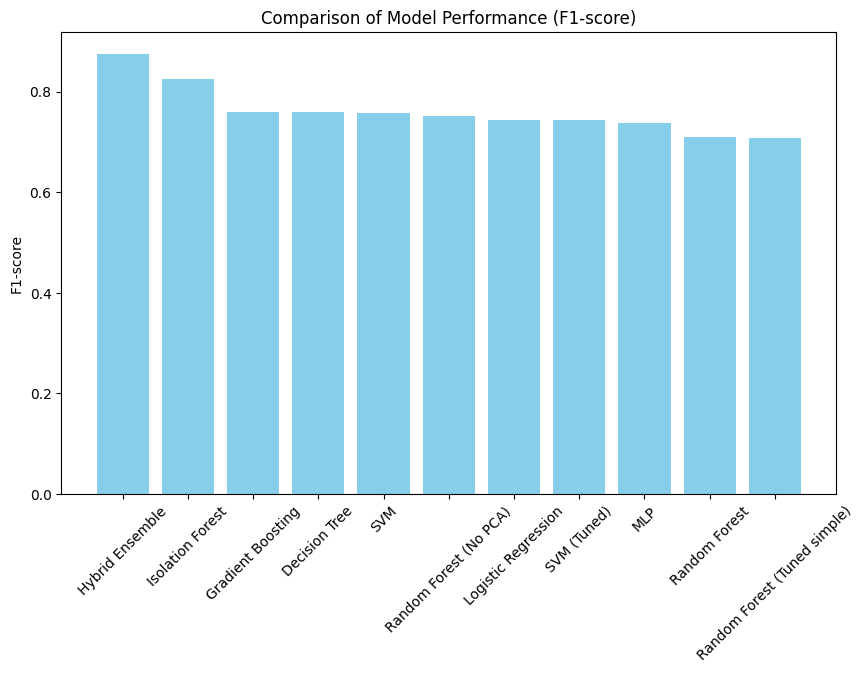

In [111]:

plt.figure(figsize=(10,6))
plt.bar(results_df.index, results_df['F1'], color='skyblue')
plt.ylabel('F1-score')
plt.title('Comparison of Model Performance (F1-score)')
plt.xticks(rotation=45)
plt.show()


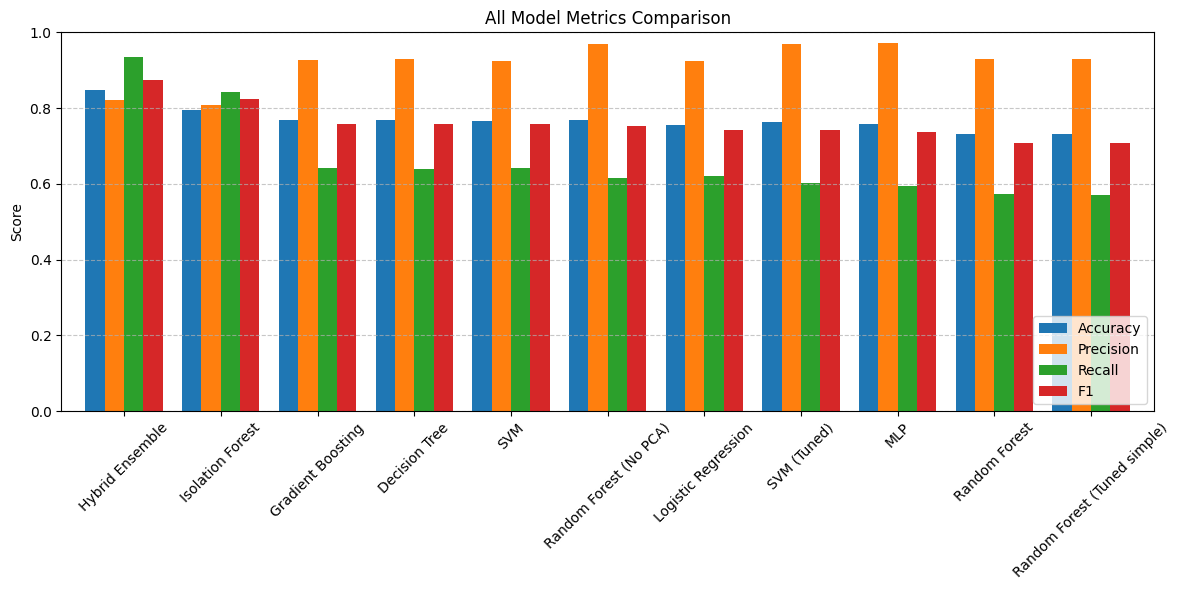

In [112]:
# Plot all metrics as grouped bars
ax = results_df[['Accuracy', 'Precision', 'Recall', 'F1']].plot(
    kind='bar', figsize=(12,6), width=0.8)

# Add titles and labels
plt.title('All Model Metrics Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)  # all metrics are between 0 and 1
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()